In [502]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler as OverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from collections import Counter

In [510]:
### Functions
def feature_transformed(df,col):
    
    enc=preprocessing.LabelEncoder()
    enc=enc.fit(df[col])
    df[col]=enc.transform(df[col])
    
    return df

def feature_importance(estimator, ax, title):
    
    feat_importances = pd.Series(estimator.feature_importances_, index=X.columns)
    feat_importances.nlargest(20).plot(kind='barh', ax=ax, title=title)
    plt.title(title)

### Part 1 ‑ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [2]:
df=pd.read_json('logins.json')
df.info()

In [4]:
df.sort_values(by='login_time', inplace=True)
df.reset_index(inplace=True,drop=True)
df.info()

In [6]:
df.head()

,login_time
0,1970-01-01 20:12:16
1,1970-01-01 20:13:18
2,1970-01-01 20:16:10
3,1970-01-01 20:16:36
4,1970-01-01 20:16:37


In [7]:
df['Num_of_Logins']=1

In [8]:
df.set_index(df.login_time, inplace=True) 
df.drop('login_time', axis=1, inplace=True)

In [9]:
#resampling for every 15 minutes interval
df_15=df.resample('15T').sum()
df_15

,Num_of_Logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


#### Logins vs. Dates for df_15

Text(0, 0.5, 'Number of Logins')

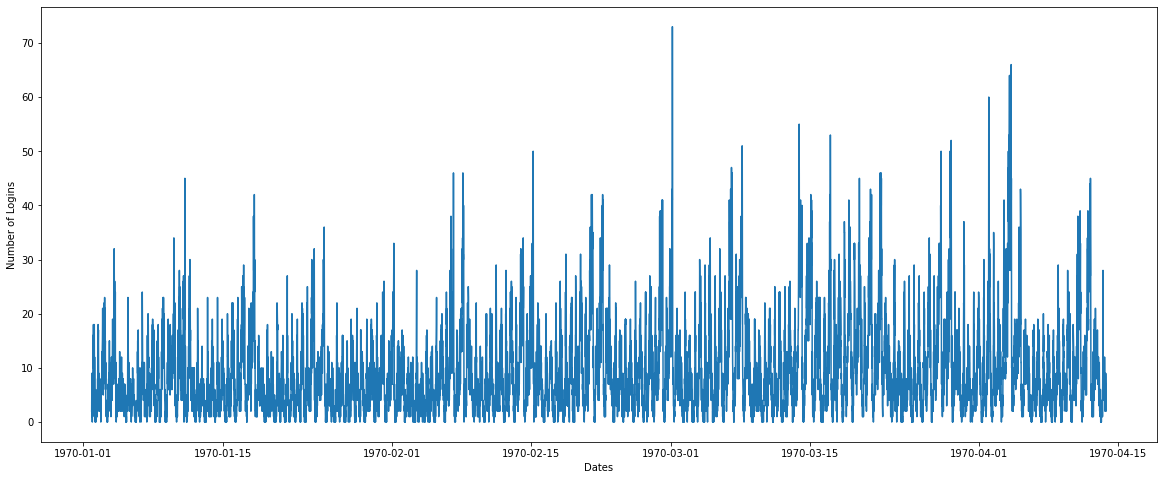

In [51]:
plt.figure(figsize=(20,8))
plt.plot(df_15)
plt.xlabel('Dates')
plt.ylabel('Number of Logins')

#### Looks like there is a pattern here. 
#### There are 15 days chunks that look like they follow a similar pattern. At the close to 15th day, a spike occurs
#### Also the data resemble Poission Events(discrete RV) and follow poisson distribution. 
#### Number of logins every 15 mins are independent of each other and therefore the time interval between the events is exponentially distributed (Guessing since it really looks like Possion Discrete RV Distribution)

Variance = 69.36212849307718
Mean = 9.51593788312219


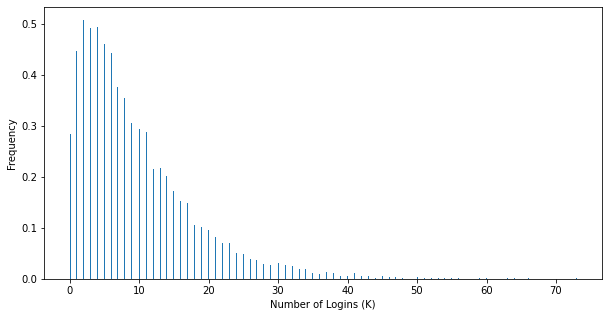

In [207]:
#Lets see distribution of the logins every 15 mins: 

plt.figure(figsize=(10,5))
plt.hist(df_15['Num_of_Logins'],bins=500,density=True)
plt.xlabel("Number of Logins (K)")
plt.ylabel("Frequency")
print("Variance = " + str(np.var(df_15['Num_of_Logins'])))
print("Mean = " + str(np.mean(df_15['Num_of_Logins'])))

#### With 500 bins I can see that indeed the dist is Poisson Distributed
#### Looks like lambda of the distribution is at 3

### Visualize data in depth

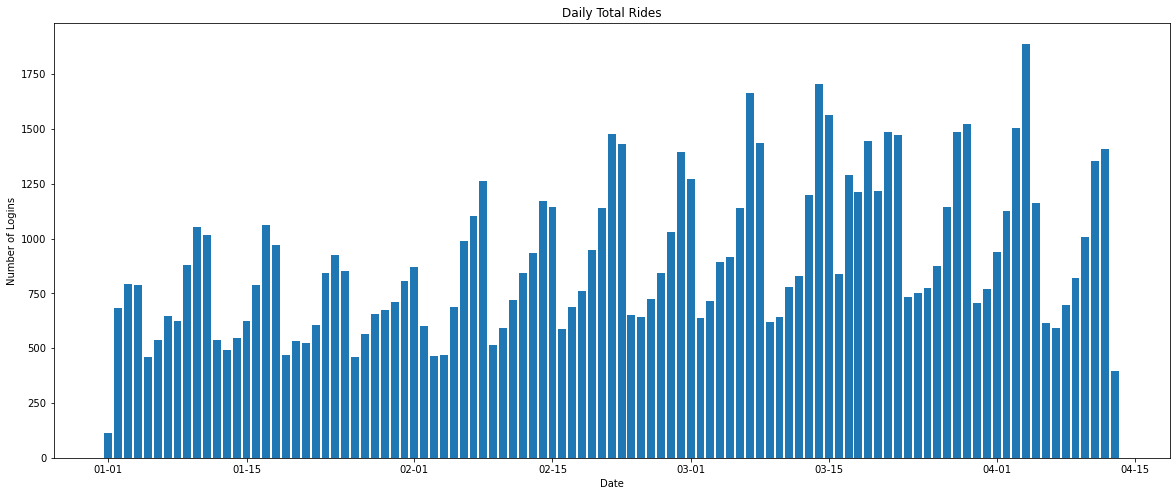

In [489]:
#resampling for every day and plotting
df_daily=df.resample('D').sum()

fig, ax = plt.subplots(figsize=(20,8))
ax.bar(df_daily.index,df_daily.Num_of_Logins)

ax.set(xlabel="Date",
       ylabel="Number of Logins",
       title="Daily Total Rides")


date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)

#### In daily time series above I can see that there are clear ups and downs which can be zoomed into to see which days the logins are high and which days logins are low.
#### Also, looks like total sum of rides increased quite a bit on 04-04. 

### How are the logins related to weekdays vs. Fri, Sat, Sunday Overall?

In [491]:
df_fri=df.resample('W-FRI').sum()
df_sat=df.resample('W-SAT').sum()
df_sun=df.resample('W-SUN').sum()

Text(0, 0.5, 'Number of Logins')

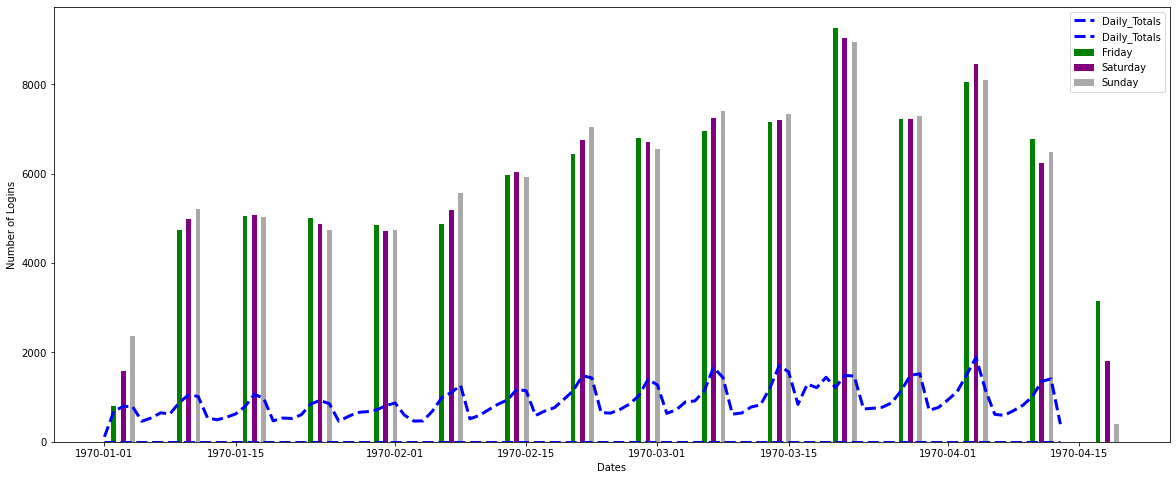

In [492]:
fig, ax = plt.subplots(figsize=(20,8))
plt.bar(df_fri.index,df_fri.Num_of_Logins, label="Friday", color='Green', width=0.5)
plt.bar(df_sat.index,df_sat.Num_of_Logins, label="Saturday", color='Purple', width=0.5)
plt.bar(df_sun.index,df_sun.Num_of_Logins, label="Sunday", color='#A9A9A9', width=0.5)
plt.plot(df_daily,'b--', linewidth=3, label='Daily_Totals')

plt.legend()
plt.xlabel('Dates')
plt.ylabel('Number of Logins')

#### As expected the logins occur most on weekends (Friday, Sat and Sun). There is no clear pattern on which day(Fri/Sat/Sun) has more than other two days
#### Some 15 day periods have Sunday logins the most, some haves Saturday logins the most, and some have Friday logins the most

### Hourly login rates
#### What hours are most busy on daily basis?

In [493]:
df_hourly=df.resample('H').sum()
df_hourly['hour']=df_hourly.index.hour
df_hourly['day_name']=df_hourly.index.day_name()

In [494]:
df_hourly=df_hourly.groupby(['day_name','hour'])['Num_of_Logins'].mean().unstack('day_name')

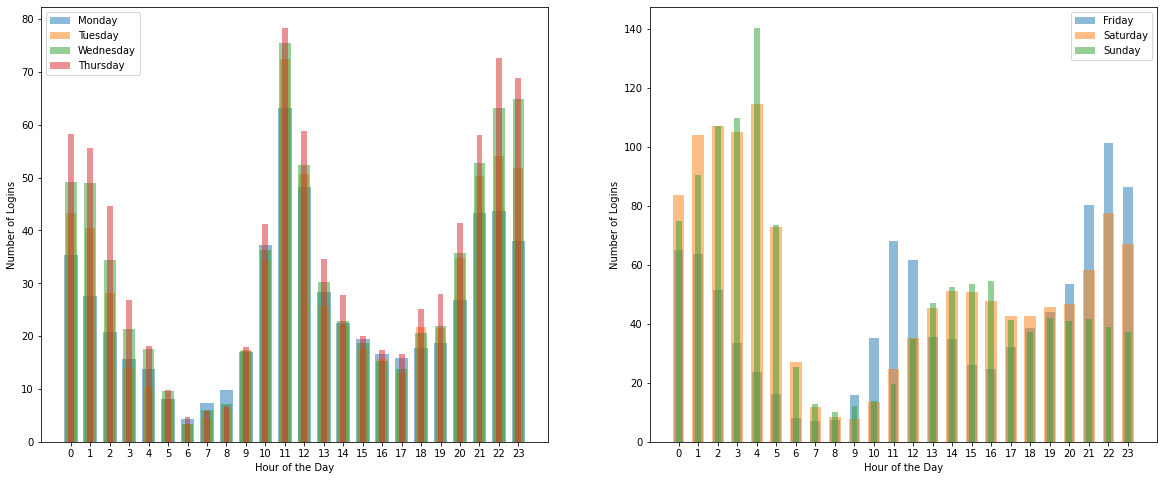

In [495]:
#fig, ax1,ax2 = plt.subplots((1,2))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.bar(df_hourly.index,df_hourly.Monday,label='Monday', width=0.7,alpha=0.5,)
ax1.bar(df_hourly.index,df_hourly.Tuesday,label='Tuesday', width=0.5, alpha=0.5,)
ax1.bar(df_hourly.index,df_hourly.Wednesday,label='Wednesday', width=0.6, alpha=0.5)
ax1.bar(df_hourly.index,df_hourly.Thursday,label='Thursday', width=0.3, alpha=0.5)
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel("Number of Logins")
ax1.set_xticks(np.arange(0,24))
ax1.legend()
ax2.bar(df_hourly.index,df_hourly.Friday,label='Friday', width=0.5,alpha=0.5)
ax2.bar(df_hourly.index,df_hourly.Saturday,label='Saturday', width=0.6, alpha=0.5)
ax2.bar(df_hourly.index,df_hourly.Sunday,label='Sunday', width=0.3, alpha=0.5)
ax2.set_xlabel('Hour of the Day')
ax2.set_ylabel("Number of Logins")
ax2.set_xticks(np.arange(0,24))

ax2.legend()


#### From right hand side's plot: On Weekends, the late hours of the night are most busy. Sunday 4 am being the most busy hour on the weekend.

#### By contrast to the weekday's, most logins are on Thurdays on almost all the hours except 7 am and 8 am.Those hours are busiest on Mondays

#### On Average, Thursday 11am has about 80 logins 
#### On Average, Sunday 4am has about 140 logins

#### Quite a fasinating find
#### Looks like people take most cabs on weekdays around 11am and not as many on weekends at that hour. Work lunch hour perhaps?

###########################################################################################################################

### Part 2: Experiment and Metric Design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

###########################################################################################################################

### My Answers:
If there are tolls being collected it means there is a record of number of cars passing from Gotham to Metropolis and vice versa. 

Since there is more activity in Gotham at night I can assume there are more drivers in Gotham at night and since there is high activity in Metropolis in day time, I can assume that there are more drivers in Metropolis in day time. 

The key measure of success would be to see that number go up after the change has been implemented. For success of Gotham to Metropolis route, we could see numbers for Gotham drivers servicing Metropolis customers during night (as there are more of those in Gotham at night during weekdays, Toll numbers from G->M should increase). For Metropolis to Gotham, since there are more drivers in Metropolis in day time we could see toll routes from M->G increase in day time. 

Night Time could be from 6pm to 6am

Day Time could be from 6am to 6 pm

### Test:
1. Hypothesis testing with 

H0: There is no change in numbers of 'toll paid routes' from G--> M at night time after the change has been made

H1: There is an increase in number of 'toll paid routes' from G--> M at night time after the change has been made

Similarly H0 and H1 for other side route will be established for day time.

Since we want to collect statistics fairly quickly, I will take the sample to perform t-test, since I am assuming I will not have alot of data (<30?), and I will not have standard deviation of the population at the time of test.  


Under H0, while performing t-test (one tail should suffice), if I find p-value smaller than the critical value at alpha=0.05, I will reject H0 in the favor of H1. If p value is greater than critical value at alpha=0.05 I will not reject H0.

### Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

In [287]:
# Create DF and explore

In [288]:
df_ret=pd.read_json('ultimate_data_challenge.json')
df_ret.info()
df_ret['signup_date']= pd.to_datetime(df_ret['signup_date'])
df_ret['last_trip_date']= pd.to_datetime(df_ret['last_trip_date'])
#df_ret.info()

### Which city are most users from?

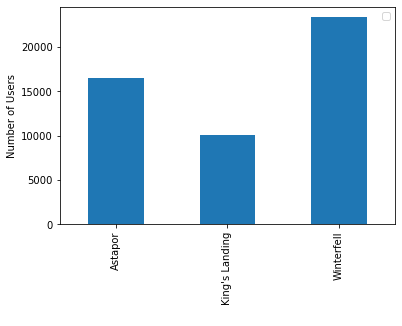

In [302]:
df_ret.groupby('city').agg({'city':'count'}).plot.bar()
plt.xlabel(' ')
plt.ylabel('Number of Users')
plt.legend('')

#Most of the users are from Winterfell

In [323]:
#Assuming the date this data was pulled is the maximum date in "last_trip_date"
date_pulled=df_ret['last_trip_date'].max()

#previos 30 days from date_pulled will be
previous_30_days= date_pulled - pd.Timedelta('30 days')

In [324]:
previous_30_days

Timestamp('2014-06-01 00:00:00')

In [326]:
#So all users who took trip on or after 2014-06-01 will be called active users
df_ret['active']= (df_ret.last_trip_date > previous_30_days)

In [329]:
df_ret.groupby('active')['active'].count()

active
False    31690
True     18310
Name: active, dtype: int64

In [498]:
#There are 18,310 users who are retained. And 31,690 users were not retained
retained_percent=round((len(df_ret[df_ret.active==True])/len(df_ret)),2)* 100

print('{} percent users were retained from all the users who signed up in January '.format(retained_percent))

37.0 percent users were retained from all the users who signed up in January 


In [361]:
#which users (active/nonactive) took more trips in first 30 days of signup on average?
s2_trips30=df_ret.groupby('active')['trips_in_first_30_days'].mean()

#which users(active/nonactive) traveled more avg_dist on average?
s1_avg_dist=df_ret.groupby(['active'])['avg_dist'].mean()

#which users(active/nonactive) traveled more in weekdays on average ?
s3_weekday_pct=df_ret.groupby(['active'])['weekday_pct'].mean()

#which users  (active/nonactive) paid more surge fees on average?
s4_avg_surge=df_ret.groupby(['active'])['avg_surge'].mean()

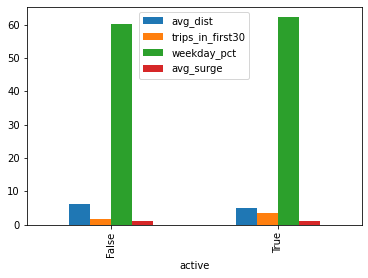

In [378]:
#Make a DF for all the above means of different features and plot them
avg_df=pd.DataFrame({'avg_dist': s1_avg_dist,'trips_in_first30':s2_trips30, 'weekday_pct':s3_weekday_pct, 'avg_surge':s4_avg_surge})
avg_df.plot.bar()

#### On average seems like people who are not retained users, traveled more miles per trip(s1_avg_dist). 
#### Maybe these users needed 1 long trip and then had no use of the service

#### On average retained users took 3.34 trips in first 30 days where as non_retained users tool 1.66 trips (s2_trips30)
#### Could be a factor in retention?

#### On average percent of trips traveled in a weekday was more for retained user than for non_retained. 
#### Same theory here - Maybe non-retained users take few very long trips on weekends??

In [499]:
### FILL NAN: 

#phone
df_ret.phone.fillna('iphone', inplace=True)

#Av rating of driver
df_ret.groupby(['active'])['avg_rating_of_driver'].mean()
#active and nonactive users have given on average same ratings to their driver. I will use 
#average of 'avg_rating_of_driver' to fillna the rows with NaN
df_ret.avg_rating_of_driver.fillna(np.mean(df_ret.avg_rating_of_driver), inplace=True)

#avg_rating_by_driver
df_ret.groupby(['active'])['avg_rating_by_driver'].mean()

#active and nonactive users got same ratings from their drivers. I will use 
#average of 'avg_rating_by_driver' to fillna the rows with NaN
df_ret.avg_rating_by_driver.fillna(np.mean(df_ret.avg_rating_by_driver), inplace=True)


In [422]:
feature_transformed(df_ret,'city')
feature_transformed(df_ret,'phone')
feature_transformed(df_ret,'ultimate_black_user')
feature_transformed(df_ret,'active')

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,1,4,2014-01-25,4.700000,1.10,2014-06-17,1,15.4,1,46.2,3.67,5.0,1
1,0,0,2014-01-29,5.000000,1.00,2014-05-05,0,0.0,0,50.0,8.26,5.0,0
2,0,3,2014-01-06,4.300000,1.00,2014-01-07,1,0.0,0,100.0,0.77,5.0,0
3,1,9,2014-01-10,4.600000,1.14,2014-06-29,1,20.0,1,80.0,2.36,4.9,1
4,2,14,2014-01-27,4.400000,1.19,2014-03-15,0,11.8,0,82.4,3.13,4.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,0,2014-01-25,5.000000,1.00,2014-06-05,1,0.0,0,100.0,5.63,4.2,1
49996,0,1,2014-01-24,4.601559,1.00,2014-01-25,1,0.0,0,0.0,0.00,4.0,0
49997,2,0,2014-01-31,5.000000,1.00,2014-05-22,0,0.0,1,100.0,3.86,5.0,0
49998,0,2,2014-01-14,3.000000,1.00,2014-01-15,1,0.0,0,100.0,4.58,3.5,0


In [503]:
#Create train test sets
X=df_ret.drop(['active','signup_date','last_trip_date'], axis=1) #dropping all date cols as models can't work with them
y=df_ret['active'] #target

In [504]:
# see the distributions of the classes before SMOTE (Synthetic Minority Oversampling Technique)
counter = Counter(y)
counter
#class 1= retained_users
#class 0 = non_retained users

Counter({1: 18310, 0: 31690})

In [505]:
X_train,X_test, y_train, y_test=train_test_split(X,y, random_state=0)

In [506]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [507]:
# see the distributions of the classes after SMOTE
counter = Counter(y_train)
counter

Counter({1: 23748, 0: 23748})

### Using Random Forests With Defaults

In [508]:

RF=RandomForestClassifier()
RF.fit(X_train, y_train)

y_pred_RF=RF.predict(X_test)

accuracy_score(y_test, y_pred_RF)

0.76248

In [509]:
tn, fp, fn, tp =confusion_matrix(y_test, y_pred_RF).ravel()
print('TN= {}'.format(tn))
print('FP= {}'.format(fp))
print('FN= {}'.format(fn))
print('TP= {}'.format(tp))

TN= 6289
FP= 1653
FN= 1316
TP= 3242


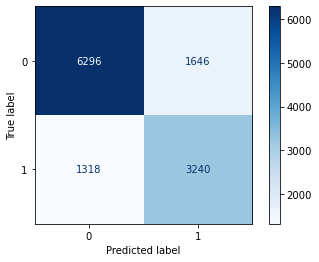

In [472]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(RF, X_test, y_test, cmap=plt.cm.Blues)

In [480]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_RF))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      7942
           1       0.66      0.71      0.69      4558

    accuracy                           0.76     12500
   macro avg       0.75      0.75      0.75     12500
weighted avg       0.77      0.76      0.76     12500



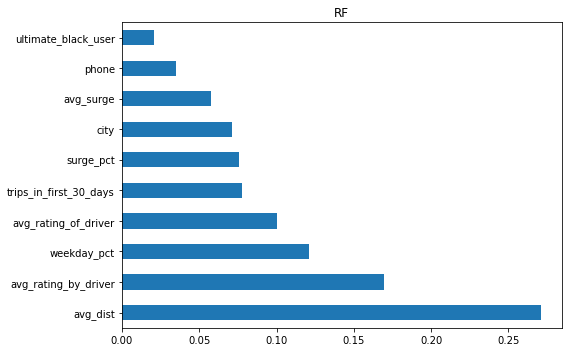

In [511]:
#Feature Importance (RF)
fig, axes=plt.subplots(1,1, figsize=(8,5))
feature_importance(RF, axes, 'RF')
plt.tight_layout()

### I chose Random Forest with it's default values as it is probably the best out of box classifier. 
### It produced a test accuracy of 76% which is good for practical data. Probably could be better if I try different parameters 

### Concerns:
##### The data being imbalanced throughs challenges in predicting the retention users. Using SMOTE, I oversampled data and artificially made it balanced. 
##### Since the positive class is 1 = users_retended and it is in minority, I wanted to see how recall and precision scores are affected.  for class 1 recall=0.71 and precision=0.66, which means the model doesn't predict as many false negatives (i.e. retention users tagged as non_retention user) as it does FP( non_retention users tagged as retention user). This aligns well with the target at hand i.e. help Ultimate to find right people who will retain after 6 months

## 3. Insights Gained

Ultimate can look at avg_dist, avg_rating_by_driver, weekday_pct of a user closely. In order to make retention numbers better ultimate can engage with users, probably earlier on to give them incentives to take longer drives or incentives to rate drivers after their trips. 